# Analysis:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import numpy as np
# from clean_chess_game_log import main_cleanup
# _, _, _ = main_cleanup('../data/dest.pgn')

In [30]:
plt.style.use('seaborn-whitegrid')

### Pre-game factors:
- Start time
- Day of the week
- Day of the month
- Game time
- ELO
- __Assigned by Computer:__
    - Pieces color
    - Opp ELO
    - ELO diff (ELO - Opp ELO)

### In-game factors:
- Castled and where
- Castled at move #
- Opp castled and where
- Opp castled at move #

### Post-game factors:
- Number of moves
- Total time used
- Opp total time used
- Outcome via

### Given the data and analysis
- __Probability could be calculated given pre-game factors__
- __Could the game improve by controlling__
    - If, when, and where to castle?
    - Total number of moves to make?
    - Total time to use?

### Probability calculations:
- User enters their Chess.com user name
- Picks game time
- Once the game starts, user enters:
    - Opp ELO
    - Assigned color

__Using Chess API__
- Retrieve the users game log
- Create a model
- Give the user probability of winning in %

### First load the data

In [5]:
df = pd.read_csv('../data/use_for_analysis.csv')

### Changes to data:
 - Changing queen-side castling to 0.5
 - Changing no castling to 0.0
 - Changing index to date

In [6]:
df.loc[:, 'castled'] = np.where(df.castled == 0, 0.5, np.where(df.castled == -1, 0, df.castled))
df.loc[:, 'opp_castled'] = np.where(df.opp_castled == 0, 0.5, np.where(df.opp_castled == -1, 0, df.opp_castled))
df.loc[:, 'date'] = pd.to_datetime(df.date)
df.index = df.date
df.drop(columns=['date'], inplace=True)

### Creating three datasets:
 1. daily_average_df: Average values of everyday
 2. daily_df_ending: Keeping only the last value of the day
 3. game_by_game_avg_df: Rolling average from the beginning by each game

In [7]:
daily_average_df = df.rolling(window='D').mean().reset_index().drop_duplicates(subset='date', keep='last')
daily_df_ending = df.reset_index().drop_duplicates(subset='date', keep='last')

In [9]:
game_by_game_avg_df = pd.DataFrame()
ndf = df.reset_index().copy()
for col in df.columns:
    if col != 'date':
        for i in ndf.index:
            game_by_game_avg_df.loc[i, col] = ndf.loc[0:i, col].mean()

### Graph One:
__My ELO rating over time compared with Opposition's ELO rating__

In [10]:
trace_comp0 = go.Scatter(x=daily_average_df.date,
                         y=daily_average_df.elo,
                         marker={'color': 'blue'},
                         opacity=0.5,
                         name='My ELO Rating')

trace_comp1 = go.Scatter(x=daily_average_df.date,
                         y=daily_average_df.opp_elo,
                         marker={'color': 'red'},
                         opacity=0.25,
                         name='Opp ELO Rating')
data_comp = [trace_comp0, trace_comp1]
layout_comp = go.Layout(title='My ELO v Opp ELO',
                        hovermode='closest',
                        xaxis={'title': 'Date', 'type': 'date'},
                        yaxis={'title': 'ELO Rating'})
fig_comp = go.Figure(data=data_comp, layout=layout_comp)
iplot(fig_comp, filename='ELO')

### Graph Two:
__Just my ELO rating over time__

In [12]:
trace1 = go.Scatter(x=daily_average_df.date[2:],
                    y=daily_average_df.elo[2:])

data = [trace1]
layout = go.Layout(title='Daily ELO Rating Over Time',
                   xaxis={'title': 'Date', 'type': 'date'},
                   yaxis={'title': 'ELO Rating'})
figure = go.Figure(data=data, layout=layout)
iplot(figure, filename='DELOROT')

### Graph Three:
__Just opposition's ELO rating over time__

In [14]:
trace2 = go.Scatter(x=daily_average_df.date[2:],
                    y=daily_average_df.opp_elo[2:])

data = [trace2]
layout = go.Layout(title='Daily Opposition ELO Rating Over Time',
                   xaxis={'title': 'Date', 'type': 'date'},
                   yaxis={'title': 'Opposition ELO Rating'})
figure = go.Figure(data=data, layout=layout)
iplot(figure, filename='DOELOROT')

### Graph Four:
__Difference in my and opposition's ELO rating over time__ <br>
Negative means opposition's ELO rating is higher than mine

In [15]:
trace3 = go.Scatter(x=daily_average_df.date[2:],
                    y=daily_average_df['diff'][2:])

data = [trace3]
layout = go.Layout(title='Daily Average DDifference in ELO Rating Over Time',
                   xaxis={'title': 'Date', 'type': 'date'},
                   yaxis={'title': 'Difference in ELO'})
figure = go.Figure(data=data, layout=layout)
iplot(figure, filename='DDELOROT')

### Winning Percentage graphs:
 1. Based on the day of the week
 2. Based on where I castled
 3. Based on where the opposition castled
 4. Based on the number of games I played on that day
 5. Based on the time of the day
 6. Based on the length of the game
 7. Based on the color assigned
 8. Based on the day of the month
 9. Based on the number of moves

In [16]:
def create_grouped_df(df, col, val):
    ndf = df[df[col] == val].reset_index()
    new_df = pd.DataFrame()
    new_df.loc[:, 'date'] = ndf['date']
    for i in ndf.index:
        new_df.loc[i, 'result'] = ndf.loc[0:i, 'result'].mean()
    new_df.loc[:, 'result'] = round(new_df['result'], 4)*100
    return new_df


def create_minmax_grouped_df(df, col, mn, mx):
    ndf = df[(df[col] >= mn) & (df[col] <= mx)].reset_index()
    new_df = pd.DataFrame()
    new_df.loc[:, 'date'] = ndf['date']
    for i in ndf.index:
        new_df.loc[i, 'result'] = ndf.loc[0:i, 'result'].mean()
    new_df.loc[:, 'result'] = round(new_df['result'], 4)*100
    new_df.dropna(inplace=True)
    return new_df

In [18]:
monday_df = create_grouped_df(df, 'weekday', 0)
tuesday_df = create_grouped_df(df, 'weekday', 1)
wednesday_df = create_grouped_df(df, 'weekday', 2)
thursday_df = create_grouped_df(df, 'weekday', 3)
friday_df = create_grouped_df(df, 'weekday', 4)
saturday_df = create_grouped_df(df, 'weekday', 5)
sunday_df = create_grouped_df(df, 'weekday', 6)

wd_mo = go.Scatter(x=monday_df['date'][5:], y=monday_df['result'][5:],
                   marker={'color': 'blue'}, opacity=0.5, name='Monday')

wd_tu = go.Scatter(x=tuesday_df['date'][5:], y=tuesday_df['result'][5:],
                   marker={'color': 'green'}, opacity=0.5, name='Tuesday')

wd_we = go.Scatter(x=wednesday_df['date'][5:], y=wednesday_df['result'][5:],
                   marker={'color': 'red'}, opacity=0.5, name='Wednesday')

wd_th = go.Scatter(x=thursday_df['date'][5:], y=thursday_df['result'][5:],
                   marker={'color': 'yellow'}, opacity=0.5, name='Thursday')

wd_fr = go.Scatter(x=friday_df['date'][5:], y=friday_df['result'][5:],
                   marker={'color': 'black'}, opacity=0.5, name='Friday')

wd_sa = go.Scatter(x=saturday_df['date'][5:], y=saturday_df['result'][5:],
                   marker={'color': 'gray'}, opacity=0.5, name='Saturday')

wd_su = go.Scatter(x=sunday_df['date'][5:], y=sunday_df['result'][5:],
                   marker={'color': 'purple'}, opacity=0.5, name='Sunday')

data_wd = [wd_mo, wd_tu, wd_we, wd_th, wd_fr, wd_sa, wd_su]

layout_wd = go.Layout(title='Winning Percentage Based on Day of the Week',
                      hovermode='closest',
                      xaxis={'title': 'Date', 'type': 'date'},
                      yaxis={'title': 'Winning Percentage', 'ticksuffix': '%'})

fig_wd = go.Figure(data=data_wd, layout=layout_wd)

iplot(fig_wd, filename='weekday')

In [19]:
king_df = create_grouped_df(df, 'castled', 1)
queen_df = create_grouped_df(df, 'castled', 0.5)
noc_df = create_grouped_df(df, 'castled', 0)

ct_ki = go.Scatter(x=king_df['date'][12:], y=king_df['result'][12:],
                   marker={'color': 'blue'}, opacity=0.5, name='King-Side')

ct_qu = go.Scatter(x=queen_df['date'][12:], y=queen_df['result'][12:],
                   marker={'color': 'green'}, opacity=0.5, name='Queen-Side')

ct_nc = go.Scatter(x=noc_df['date'][12:], y=noc_df['result'][12:],
                   marker={'color': 'red'}, opacity=0.5, name='Did Not Castle')

data_ct = [ct_ki, ct_qu, ct_nc]

layout_ct = go.Layout(title='Winning Percentage Based on Where/If Castled',
                      hovermode='closest',
                      xaxis={'title': 'Date', 'type': 'date'},
                      yaxis={'title': 'Winning Percentage', 'ticksuffix': '%'})

fig_ct = go.Figure(data=data_ct, layout=layout_ct)

iplot(fig_ct, filename='castle')

In [20]:
oking_df = create_grouped_df(df, 'opp_castled', 1)
oqueen_df = create_grouped_df(df, 'opp_castled', 0.5)
onoc_df = create_grouped_df(df, 'opp_castled', 0)

cto_kio = go.Scatter(x=oking_df['date'][12:], y=oking_df['result'][12:],
                     marker={'color': 'blue'}, opacity=0.5, name='King-Side')

cto_quo = go.Scatter(x=oqueen_df['date'][12:], y=oqueen_df['result'][12:],
                     marker={'color': 'green'}, opacity=0.5, name='Queen-Side')

cto_nco = go.Scatter(x=onoc_df['date'][12:], y=onoc_df['result'][12:],
                     marker={'color': 'red'}, opacity=0.5, name='Did Not Castle')

data_cto = [cto_kio, cto_quo, cto_nco]

layout_cto = go.Layout(title='Winning Percentage Based on Where/If Opp Castled',
                       hovermode='closest',
                       xaxis={'title': 'Date', 'type': 'date'},
                       yaxis={'title': 'Winning Percentage', 'ticksuffix': '%'})

fig_cto = go.Figure(data=data_cto, layout=layout_cto)

iplot(fig_cto, filename='opp_castle')

In [21]:
ltwo_df = create_minmax_grouped_df(df, 'day_game_num', 0, 2)
three_four_df = create_minmax_grouped_df(df, 'day_game_num', 3, 4)
five_six_df = create_minmax_grouped_df(df, 'day_game_num', 5, 6)
seven_ten_df = create_minmax_grouped_df(df, 'day_game_num', 7, 10)
mten_df = create_minmax_grouped_df(df, 'day_game_num', 11, 500)

dgn_lt = go.Scatter(x=ltwo_df['date'][5:], y=ltwo_df['result'][5:],
                    marker={'color': 'blue'}, opacity=0.5, name='Less than 2')

dgn_tf = go.Scatter(x=three_four_df['date'][5:], y=three_four_df['result'][5:],
                    marker={'color': 'green'}, opacity=0.5, name='3 to 4')

dgn_fs = go.Scatter(x=five_six_df['date'][5:], y=five_six_df['result'][5:],
                    marker={'color': 'red'}, opacity=0.5, name='5 to 6')

dgn_st = go.Scatter(x=seven_ten_df['date'][5:], y=seven_ten_df['result'][5:],
                    marker={'color': 'yellow'}, opacity=0.5, name='6 to 10')

dgn_mt = go.Scatter(x=mten_df['date'][5:], y=mten_df['result'][5:],
                    marker={'color': 'black'}, opacity=0.5, name='More than 10')

data_dgn = [dgn_lt, dgn_tf, dgn_fs, dgn_st, dgn_mt]

layout_dgn = go.Layout(title='Winning Percentage Based Number of Games Played on that Day',
                       hovermode='closest',
                       xaxis={'title': 'Date', 'type': 'date'},
                       yaxis={'title': 'Winning Percentage', 'ticksuffix': '%'})

fig_dgn = go.Figure(data=data_dgn, layout=layout_dgn)

iplot(fig_dgn, filename='day_num_games')

In [22]:
midnight_six_df = create_minmax_grouped_df(df, 'start_time', 0, 6)
six_noon_df = create_minmax_grouped_df(df, 'start_time', 6.001, 12)
noon_four_df = create_minmax_grouped_df(df, 'start_time', 12.001, 16)
four_eight_df = create_minmax_grouped_df(df, 'start_time', 16.001, 20)
eight_midnight_df = create_minmax_grouped_df(df, 'start_time', 20.001, 23.999)

st_ms = go.Scatter(x=midnight_six_df['date'], y=midnight_six_df['result'],
                           marker={'color': 'blue'}, opacity=0.5, name='Midnight to 6 AM')

st_sn = go.Scatter(x=six_noon_df['date'], y=six_noon_df['result'],
                           marker={'color': 'green'}, opacity=0.5, name='6 AM to Noon')

st_nf = go.Scatter(x=noon_four_df['date'], y=noon_four_df['result'],
                           marker={'color': 'red'}, opacity=0.5, name='Noon to 4 PM')

st_fe = go.Scatter(x=four_eight_df['date'], y=four_eight_df['result'],
                           marker={'color': 'yellow'}, opacity=0.5, name='4 PM to 8 PM')

st_em = go.Scatter(x=eight_midnight_df['date'], y=eight_midnight_df['result'],
                           marker={'color': 'black'}, opacity=0.5, name='8 PM to Midnight')

data_st = [st_ms, st_sn, st_nf, st_fe, st_em]

layout_st = go.Layout(title='Winning Percentage Based on the Time of the Day',
                        hovermode='closest',
                        xaxis={'title':'Date', 'type': 'date'},
                        yaxis={'title':'Winning Percentage', 'ticksuffix': '%'})

fig_st = go.Figure(data=data_st, layout=layout_st)

iplot(fig_st, filename='start_time')

In [23]:
ten_df = create_grouped_df(df, 'game_time', 600)
five_df = create_grouped_df(df, 'game_time', 300)
three_df = create_grouped_df(df, 'game_time', 180)

gt_ten = go.Scatter(x=ten_df['date'][12:], y=ten_df['result'][12:],
                    marker={'color': 'blue'}, opacity=0.5, name='10 Minute Game')

gt_fiv = go.Scatter(x=five_df['date'][12:], y=five_df['result'][12:],
                    marker={'color': 'green'}, opacity=0.5, name='5 Minute Game')

gt_thr = go.Scatter(x=three_df['date'][12:], y=three_df['result'][12:],
                    marker={'color': 'red'}, opacity=0.5, name='3 Minute Game')

data_gt = [gt_ten, gt_fiv, gt_thr]

layout_gt = go.Layout(title='Winning Percentage Based on Game Length',
                      hovermode='closest',
                      xaxis={'title': 'Date', 'type': 'date'},
                      yaxis={'title': 'Winning Percentage', 'ticksuffix': '%'})

fig_gt = go.Figure(data=data_gt, layout=layout_gt)

iplot(fig_gt, filename='game_length')

In [24]:
white_df = create_grouped_df(df, 'color', 1)
black_df = create_grouped_df(df, 'color', 0)

cl_white = go.Scatter(x=white_df['date'][12:], y=white_df['result'][12:],
                      marker={'color': 'green'}, opacity=0.5, name='White')

cl_black = go.Scatter(x=black_df['date'][12:], y=black_df['result'][12:],
                      marker={'color': 'black'}, opacity=0.5, name='Black')

data_cl = [cl_white, cl_black]

layout_cl = go.Layout(title='Winning Percentage Based on Color Assigned',
                      hovermode='closest',
                      xaxis={'title': 'Date', 'type': 'date'},
                      yaxis={'title': 'Winning Percentage', 'ticksuffix': '%'})

fig_cl = go.Figure(data=data_cl, layout=layout_cl)

iplot(fig_cl, filename='game_length')

In [25]:
one_five_df = create_minmax_grouped_df(df, 'day', 0, 5)
six_ten_df = create_minmax_grouped_df(df, 'day', 6, 10)
eleven_fifteen_df = create_minmax_grouped_df(df, 'day', 11, 15)
sixteen_twenty_df = create_minmax_grouped_df(df, 'day', 16, 20)
twenty_twentyfive_df = create_minmax_grouped_df(df, 'day', 21, 26)
twentyfive_plus_df = create_minmax_grouped_df(df, 'day', 26, 31)

dom_of = go.Scatter(x=one_five_df['date'], y=one_five_df['result'],
                    marker={'color': 'blue'}, opacity=0.5, name='1st to 5th')

dom_st = go.Scatter(x=six_ten_df['date'], y=six_ten_df['result'],
                    marker={'color': 'green'}, opacity=0.5, name='6th to 10th')

dom_ef = go.Scatter(x=eleven_fifteen_df['date'], y=eleven_fifteen_df['result'],
                    marker={'color': 'red'}, opacity=0.5, name='11th to 15th')

dom_sw = go.Scatter(x=sixteen_twenty_df['date'], y=sixteen_twenty_df['result'],
                    marker={'color': 'yellow'}, opacity=0.5, name='16th to 20th')

dom_tt = go.Scatter(x=twenty_twentyfive_df['date'], y=twenty_twentyfive_df['result'],
                    marker={'color': 'black'}, opacity=0.5, name='21st to 25th')

dom_tp = go.Scatter(x=twentyfive_plus_df['date'], y=twentyfive_plus_df['result'],
                    marker={'color': 'purple'}, opacity=0.5, name='25th to 31st')

data_dom = [dom_of, dom_st, dom_ef, dom_sw, dom_tt, dom_tp]

layout_dom = go.Layout(title='Winning Percentage Based on the Day of the Month',
                       hovermode='closest',
                       xaxis={'title': 'Date', 'type': 'date'},
                       yaxis={'title': 'Winning Percentage', 'ticksuffix': '%'})

fig_dom = go.Figure(data=data_dom, layout=layout_dom)
iplot(fig_dom, filename='day_of_month')

In [26]:
lten_df = create_minmax_grouped_df(df, 'num_moves', 0, 10)
ten_twenty_df = create_minmax_grouped_df(df, 'num_moves', 11, 20)
twenty_thirty_df = create_minmax_grouped_df(df, 'num_moves', 21, 30)
thirty_fifty_df = create_minmax_grouped_df(df, 'num_moves', 31, 50)
fifty_seventyfive_df = create_minmax_grouped_df(df, 'num_moves', 51, 75)
seventy_plus_df = create_minmax_grouped_df(df, 'num_moves', 76, 999)

nm_lt = go.Scatter(x=lten_df['date'], y=lten_df['result'],
                   marker={'color': 'blue'}, opacity=0.5, name='Less than 10 Moves')

nm_tt = go.Scatter(x=ten_twenty_df['date'], y=ten_twenty_df['result'],
                   marker={'color': 'green'}, opacity=0.5, name='11 to 20 Moves')

nm_th = go.Scatter(x=twenty_thirty_df['date'], y=twenty_thirty_df['result'],
                   marker={'color': 'red'}, opacity=0.5, name='21 to 30 Moves')

nm_tf = go.Scatter(x=thirty_fifty_df['date'], y=thirty_fifty_df['result'],
                   marker={'color': 'yellow'}, opacity=0.5, name='30 to 50 Moves')

nm_fs = go.Scatter(x=fifty_seventyfive_df['date'], y=fifty_seventyfive_df['result'],
                   marker={'color': 'black'}, opacity=0.5, name='50 to 75 Moves')

nm_ms = go.Scatter(x=seventy_plus_df['date'], y=seventy_plus_df['result'],
                   marker={'color': 'purple'}, opacity=0.5, name='More than 75 Moves')

data_nm = [nm_lt, nm_tt, nm_th, nm_tf, nm_fs, nm_ms]

layout_nm = go.Layout(title='Winning Percentage Based on the Number of Moves/Player',
                      hovermode='closest',
                      xaxis={'title': 'Date', 'type': 'date'},
                      yaxis={'title': 'Winning Percentage', 'ticksuffix': '%'})

fig_nm = go.Figure(data=data_nm, layout=layout_nm)
iplot(fig_nm, filename='num_moves')

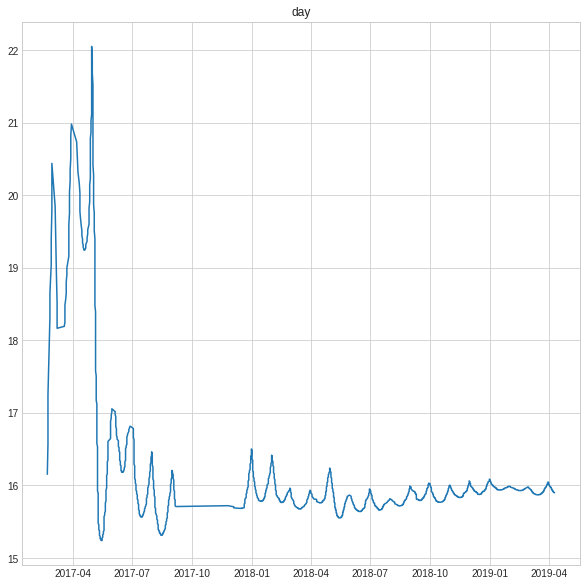

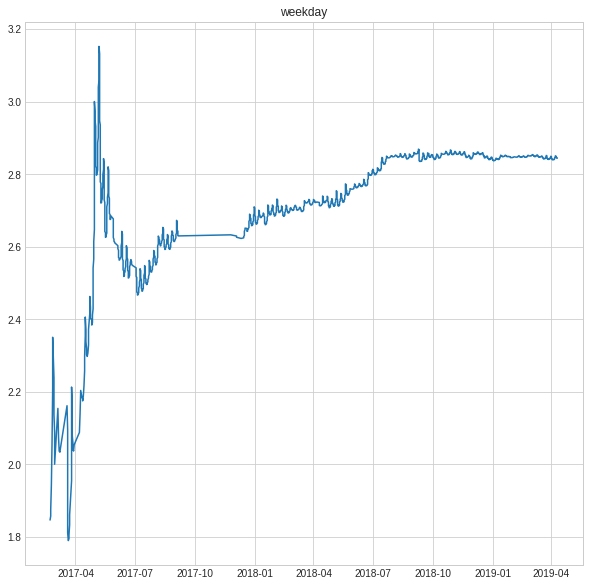

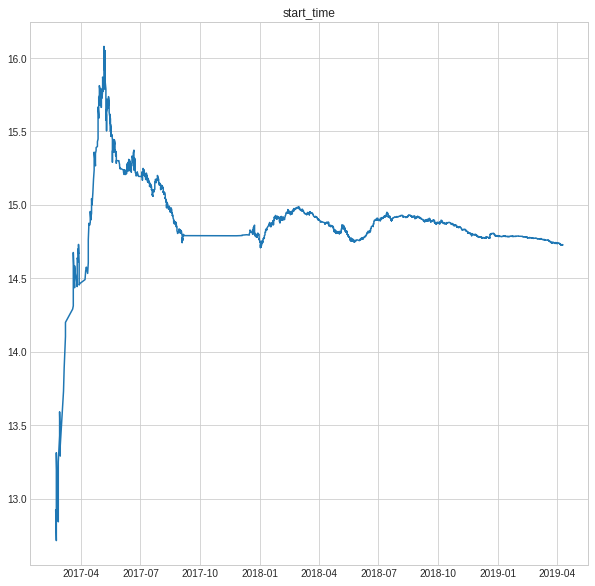

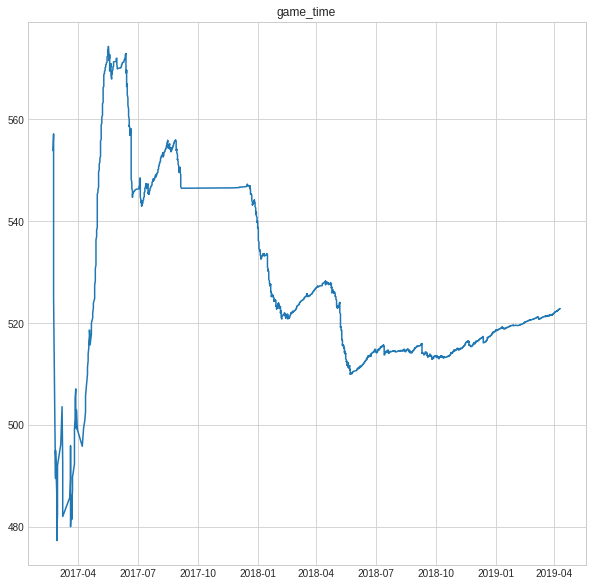

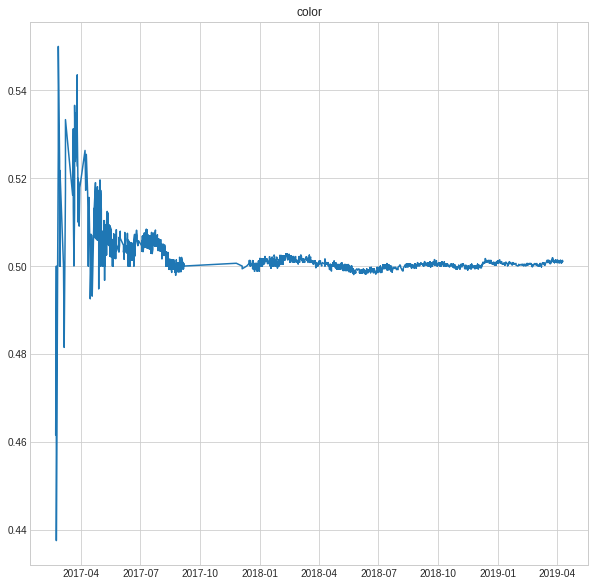

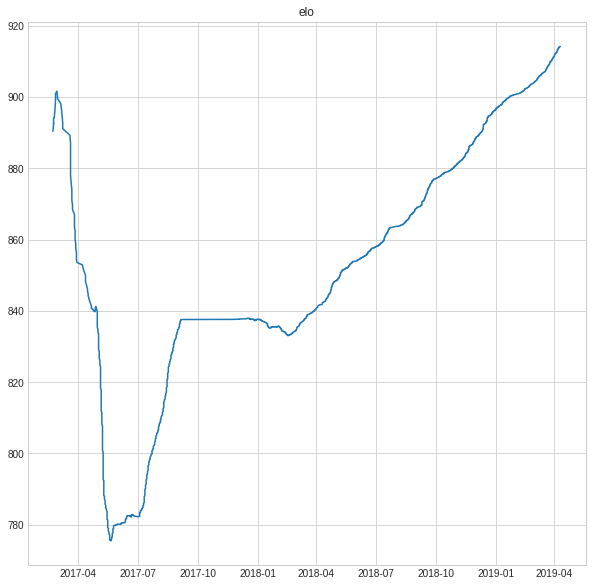

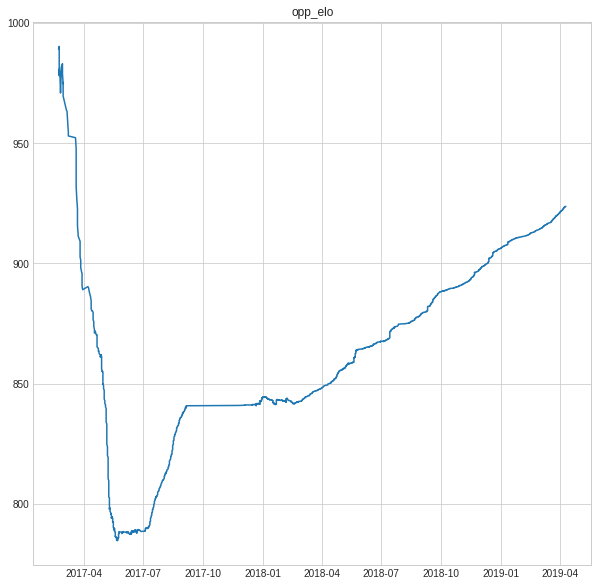

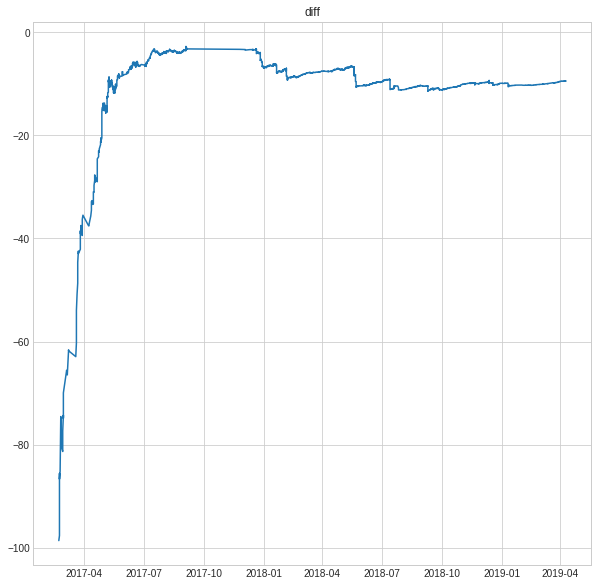

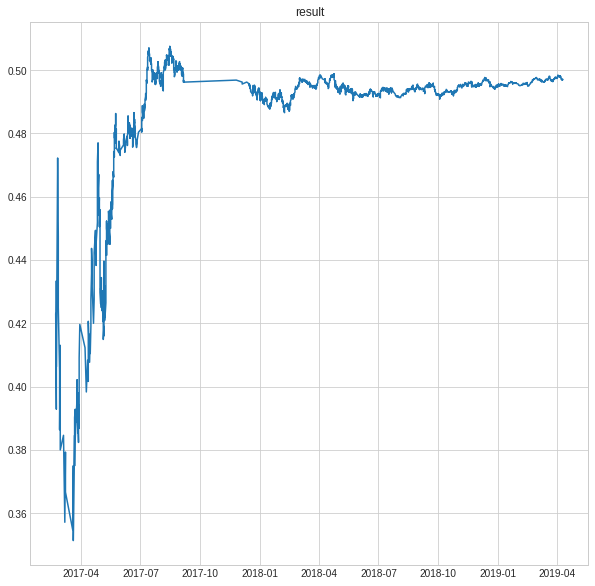

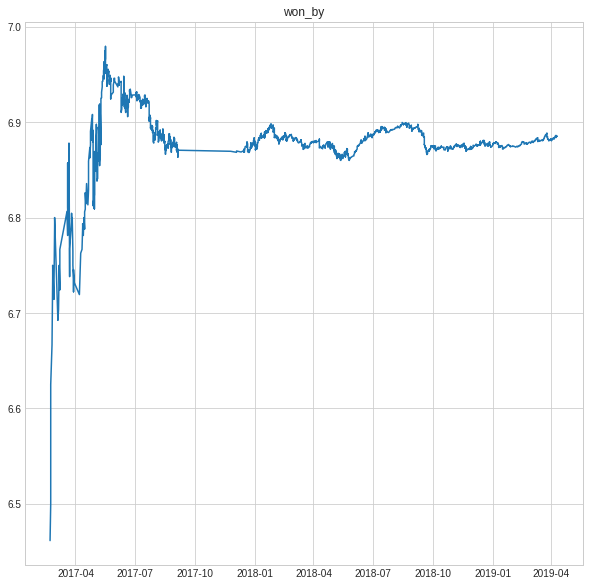

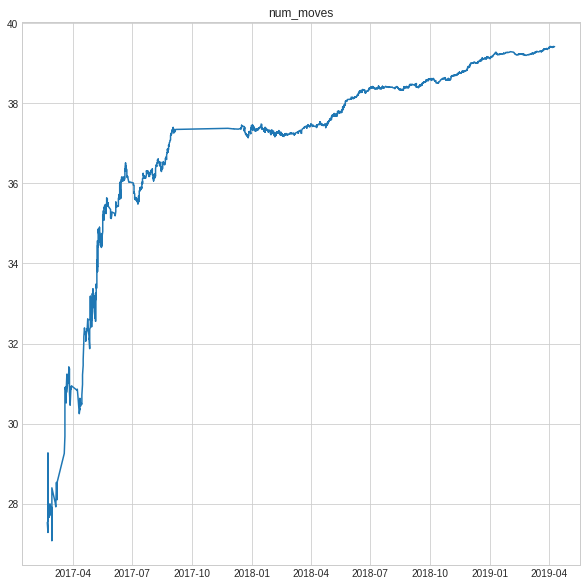

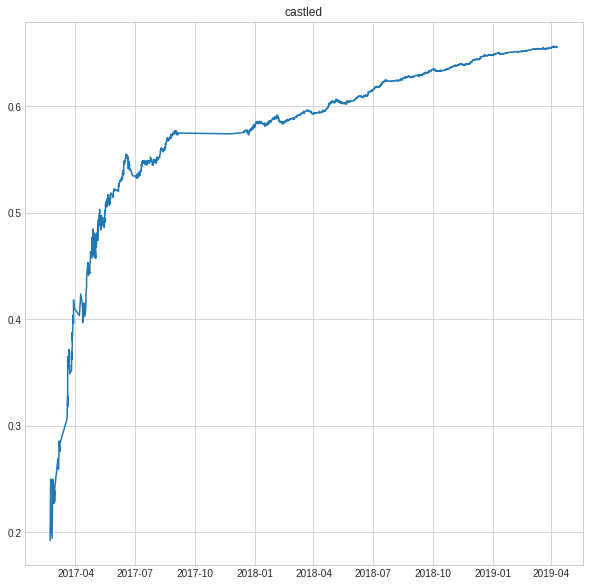

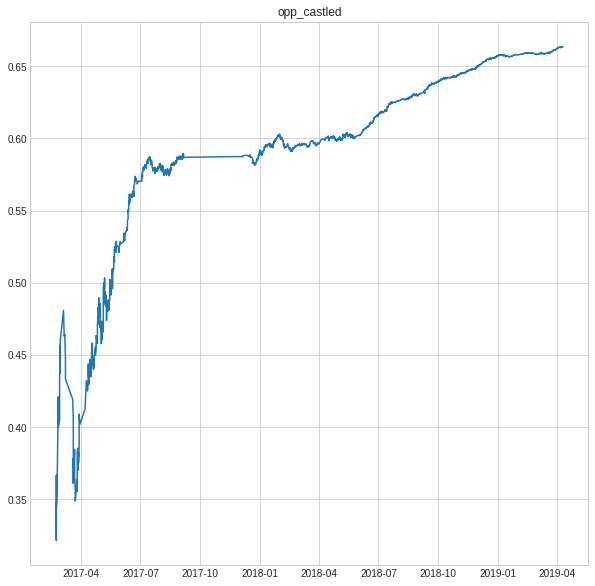

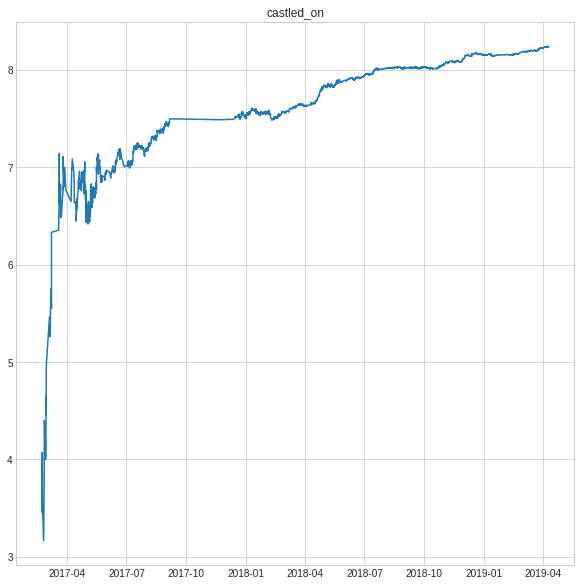

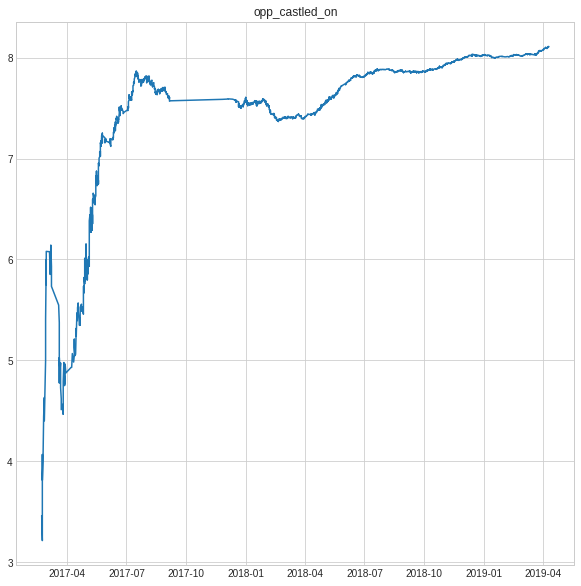

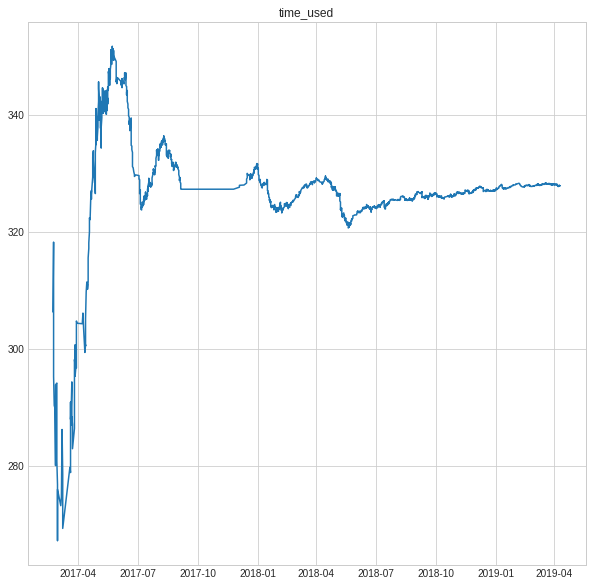

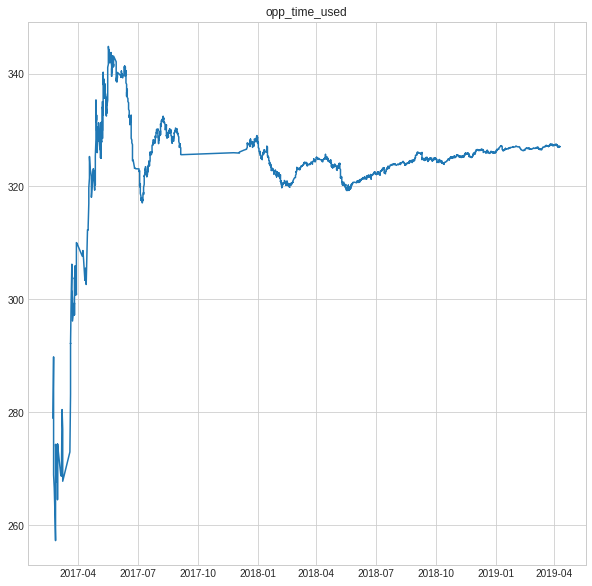

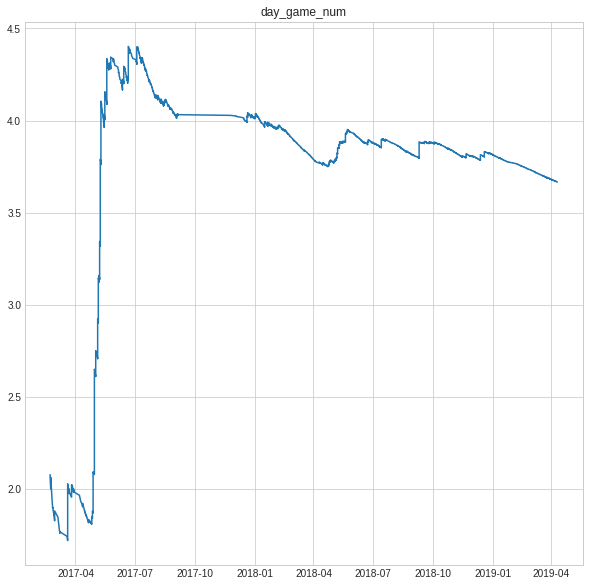

In [31]:
game_by_game_avg_df.loc[:, 'date'] = ndf['date']
for col in df.columns:
    if col != 'date':
        plt.figure(figsize=(10,10))
        plt.plot(game_by_game_avg_df['date'][12:], game_by_game_avg_df[col][12:], marker=None)
        plt.title(col)
        plt.show()

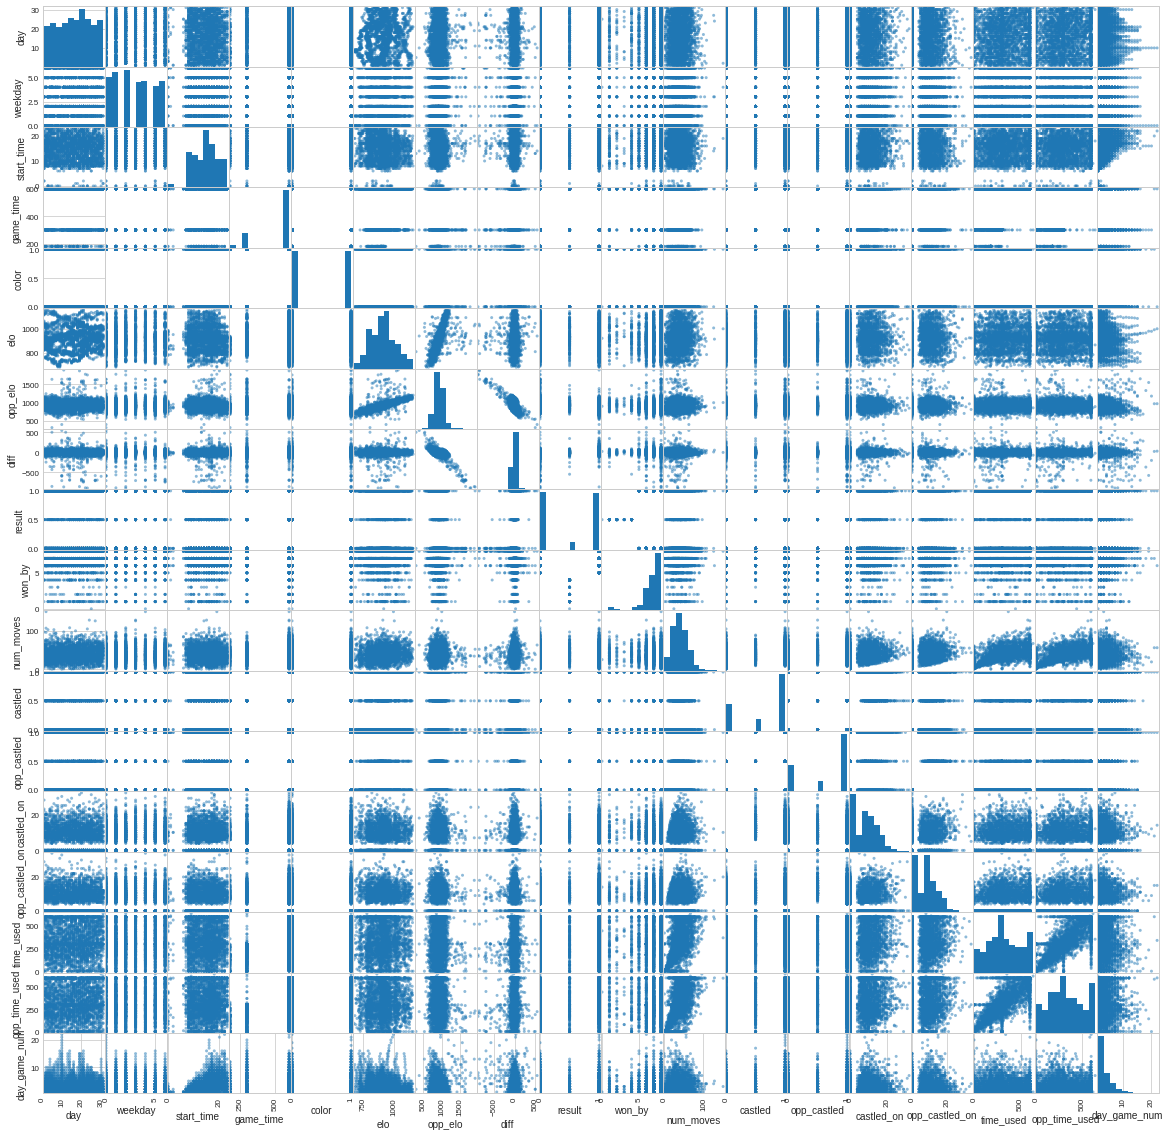

<Figure size 432x288 with 0 Axes>

In [32]:
pd.plotting.scatter_matrix(df, figsize=(20, 20))
plt.show()
plt.savefig('plt.png')